C:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\_shared\utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


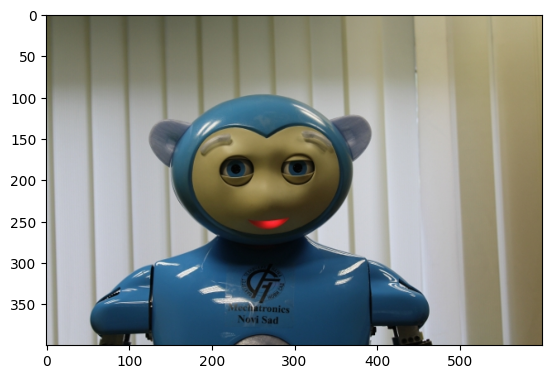

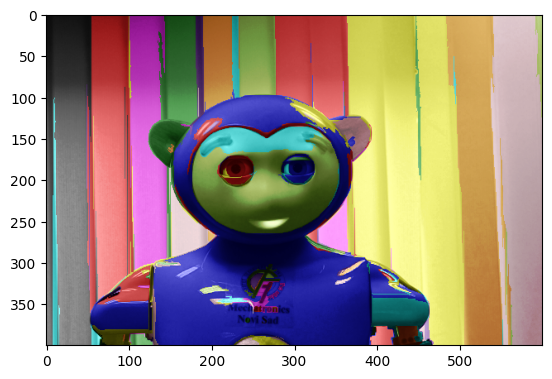

In [1]:
import numpy as np
from skimage import io, color, segmentation, exposure
import matplotlib.pyplot as plt
import networkx as nx

# Load the input image
image = io.imread("C:/Users/dell/Documents/Processing/examples/robotmarko.jpg")
#print("Image shape:", image.shape)

threshold = 0.1

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Apply the Felzenszwalb algorithm for segmentation
segmentation_results = segmentation.felzenszwalb(gray_image, scale=100, sigma=0.5)

# Create an undirected graph G
G = nx.Graph()

# Add nodes to the graph
num_nodes = np.max(segmentation_results) + 1
G.add_nodes_from(range(num_nodes))

# Iterate over the image pixels and add edges to the graph
rows, cols = segmentation_results.shape
for i in range(rows - 1):
    for j in range(cols - 1):
        current_segment = segmentation_results[i, j]
        right_segment = segmentation_results[i, j + 1]
        bottom_segment = segmentation_results[i + 1, j]
        diagonal_segment = segmentation_results[i + 1, j + 1]
        
        if current_segment != right_segment:
            edge_weight = np.abs(gray_image[i, j] - gray_image[i, j + 1])
            G.add_edge(current_segment, right_segment, weight=edge_weight)
        
        if current_segment != bottom_segment:
            edge_weight = np.abs(gray_image[i, j] - gray_image[i + 1, j])
            G.add_edge(current_segment, bottom_segment, weight=edge_weight)
        
        if current_segment != diagonal_segment:
            edge_weight = np.abs(gray_image[i, j] - gray_image[i + 1, j + 1])
            G.add_edge(current_segment, diagonal_segment, weight=edge_weight)    

# Merge segments based on the given condition
for edge in sorted(G.edges(data=True), key=lambda x: x[2]['weight']):
    segment1 = edge[0]
    segment2 = edge[1]
    weight = edge[2]['weight']
    
    if weight <= threshold and segmentation_results.max() > 1:
        merged_segment = min(segment1, segment2)
        segmentation_results[segmentation_results == segment1] = merged_segment
        segmentation_results[segmentation_results == segment2] = merged_segment

# Save the segmented output image
segmented_image = color.label2rgb(segmentation_results, image, kind='overlay')
segmented_image = exposure.rescale_intensity(segmented_image, out_range=(0, 255))
segmented_image = segmented_image.astype(np.uint8)
io.imsave('segmented_image.jpg', segmented_image)

# Apply histogram equalization to enhance contrast
enhanced_image = exposure.equalize_hist(segmented_image)

# Display the image
plt.imshow(image)
plt.show()
plt.imshow(enhanced_image)
plt.show()
